<a href="https://colab.research.google.com/github/Zandersan/portifolio/blob/main/debinha_niko_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning para Classificação de Gatos e Cachorros

# Projeto completo com tratamento de erros e upload de imagens

In [2]:
# ## 1. Configuração Inicial

# %%
# Importar bibliotecas
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, Javascript
from base64 import b64decode
from io import BytesIO
import warnings

In [3]:
# Configurações
warnings.filterwarnings('ignore')  # Ignorar avisos não críticos
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
base_dir = '/tmp/PetImages'

In [4]:
# Verificar GPU
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

GPU disponível: []


In [5]:
# ## 2. Download e Preparação do Dataset

# Download do dataset
!wget --no-check-certificate \
    https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip \
    -O /tmp/cats-and-dogs.zip

--2025-07-31 11:45:27--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.218.186.12, 2600:1409:9800:158d::317f, 2600:1409:9800:1583::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.218.186.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   187MB/s    in 4.2s    

2025-07-31 11:45:31 (186 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [6]:
# Extrair arquivos
with zipfile.ZipFile('/tmp/cats-and-dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp')

# Verificar estrutura
!ls /tmp/PetImages

Cat  Dog


In [7]:
# ## 3. Limpeza do Dataset

# Função para remover imagens corrompidas
def clean_dataset(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
                img.close()
            except (IOError, SyntaxError):
                corrupted.append(file_path)
                os.remove(file_path)
    print(f"Removidos {len(corrupted)} arquivos corrompidos")
    return corrupted

In [8]:
# Limpar dataset
print("Limpando imagens de gatos...")
corrupted_cats = clean_dataset(os.path.join(base_dir, 'Cat'))
print("Limpando imagens de cachorros...")
corrupted_dogs = clean_dataset(os.path.join(base_dir, 'Dog'))

Limpando imagens de gatos...
Removidos 2 arquivos corrompidos
Limpando imagens de cachorros...
Removidos 2 arquivos corrompidos


In [9]:
# ## 4. Preparação dos Geradores de Dados

# Data augmentation e normalização
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [10]:
# Gerador seguro com tratamento de erros
def safe_generator(datagen, directory, subset):
    generator = datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset=subset,
        shuffle=(subset == 'training'))

    original_method = generator._get_batches_of_transformed_samples

    def wrapped_method(*args, **kwargs):
        try:
            return original_method(*args, **kwargs)
        except Exception as e:
            print(f"Erro no batch: {str(e)} - Pulando...")
            return next(generator)

    generator._get_batches_of_transformed_samples = wrapped_method
    return generator

In [11]:
# Criar geradores
train_generator = safe_generator(train_datagen, base_dir, 'training')
validation_generator = safe_generator(train_datagen, base_dir, 'validation')

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [12]:
# Verificar classes
print("\nClasses:", train_generator.class_indices)


Classes: {'Cat': 0, 'Dog': 1}


In [13]:
# ## 5. Construção do Modelo

# Carregar modelo base
base_model = MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Congelar camadas

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Construir modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [15]:
# Compilar
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
# ## 6. Treinamento do Modelo

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [17]:
# Função para calcular steps seguros
def safe_steps(generator):
    return max(1, generator.samples // BATCH_SIZE)

# Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=safe_steps(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=safe_steps(validation_generator),
    callbacks=callbacks
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.7783 - loss: 0.4652

625/625 ━━━━━━━━━━━━━━━━━━━━ 602s 952ms/step - accuracy: 0.7784 - loss: 0.4650 - val_accuracy: 0.9281 - val_loss: 0.1876
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.9217 - loss: 0.1928

625/625 ━━━━━━━━━━━━━━━━━━━━ 624s 957ms/step - accuracy: 0.9218 - loss: 0.1928 - val_accuracy: 0.9445 - val_loss: 0.1472
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9411 - loss: 0.1450

625/625 ━━━━━━━━━━━━━━━━━━━━ 621s 955ms/step - accuracy: 0.9411 - loss: 0.1450 - val_accuracy: 0.9491 - val_loss: 0.1313
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9446 - loss: 0.1369

625/625 ━━━━━━━━━━━━━━━━━━━━ 594s 950ms/step - accuracy: 0.9446 - loss: 0.1368 - val_accuracy: 0.9533 - val_loss: 0.1142
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 628s 959ms/step - accuracy: 0.9488 - loss: 0.1279 - val_accuracy: 0.9533 - val_loss: 0.1144
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.9506 - loss: 0.1172

625/625 ━━━━━━━━━━━━━━━━━━━━ 622s 994ms/step - accuracy: 0.9506 - loss: 0.1172 - val_accuracy: 0.9569 - val_loss: 0.1101
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9551 - loss: 0.1104

625/625 ━━━━━━━━━━━━━━━━━━━━ 594s 950ms/step - accuracy: 0.9551 - loss: 0.1104 - val_accuracy: 0.9581 - val_loss: 0.1055
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 626s 958ms/step - accuracy: 0.9545 - loss: 0.1128 - val_accuracy: 0.9565 - val_loss: 0.1058
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9529 - loss: 0.1098

625/625 ━━━━━━━━━━━━━━━━━━━━ 631s 972ms/step - accuracy: 0.9529 - loss: 0.1098 - val_accuracy: 0.9593 - val_loss: 0.1017
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.9568 - loss: 0.1079

625/625 ━━━━━━━━━━━━━━━━━━━━ 623s 998ms/step - accuracy: 0.9568 - loss: 0.1079 - val_accuracy: 0.9625 - val_loss: 0.0965


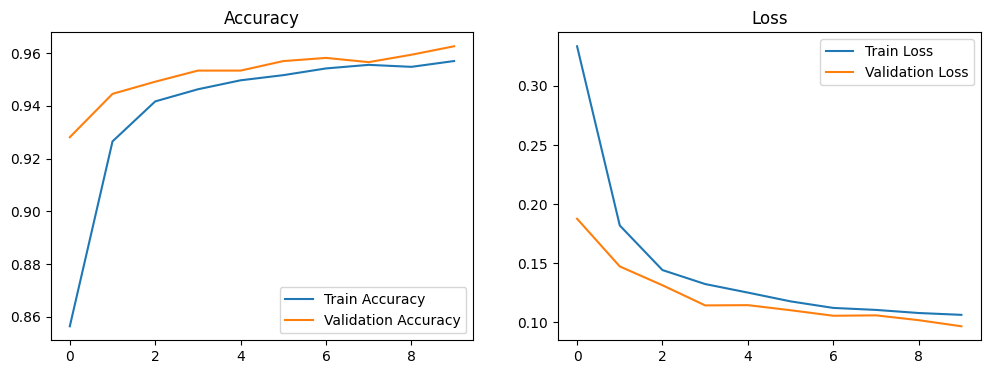

In [18]:
# ## 7. Avaliação e Visualização

# Plotar histórico de treino
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [19]:
# Avaliação final
val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nAcurácia final: {val_acc:.2%}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 120s 760ms/step - accuracy: 0.9518 - loss: 0.1032

Acurácia final: 95.48%


In [20]:
# Função para fazer upload de imagens
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Arquivo recebido: {filename}")
        return filename
    return None

In [21]:
# Função para preparar imagem
def prepare_image(path):
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Criar batch
    return img_array / 255.0  # Normalizar

In [22]:
# Função para prever e mostrar resultado
def predict_and_show(model, image_path):
    img_array = prepare_image(image_path)
    prediction = model.predict(img_array)
    prob = prediction[0][0]

    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.show()

    if prob > 0.5:
        print(f"Probabilidade: {prob:.2%} → Cachorro")
    else:
        print(f"Probabilidade: {1-prob:.2%} → Gato")


Faça upload de uma imagem de gato ou cachorro


Saving Debinha.jpeg to Debinha.jpeg
Arquivo recebido: Debinha.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


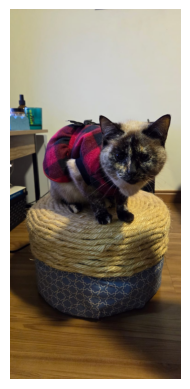

Probabilidade: 85.34% → Gato


In [23]:
# Testar com upload
print("Faça upload de uma imagem de gato ou cachorro")
uploaded_file = upload_image()

if uploaded_file:
    predict_and_show(model, uploaded_file)
else:
    print("Nenhum arquivo foi enviado")

In [24]:
# ## 9. Salvar Modelo

# Salvar modelo completo
model.save('cats_vs_dogs_classifier.h5')
print("Modelo salvo como 'cats_vs_dogs_classifier.h5'")

Modelo salvo como 'cats_vs_dogs_classifier.h5'
